In [1]:
#| default_exp ECMs.priming

In [2]:
#| export
import numpy as np
from projective_simulation.ECMs.template_ECM import ECM
from projective_simulation.ECMs.two_layer import Two_Layer
from projective_simulation.utils import _softmax

class Priming_ECM(Two_Layer):
    '''
    This sub-class of the Two-Layer ECM adds a variable for action priming.
    This variable should be a list of floats, each element of which corresponds to an action in the ECM.
    These "priming values" are summed with h-values of any edge connected to the associated action node prior to calculating walk probabilites with the softmax function
    '''
    def __init__(self, 
                 num_actions: int, # The number of available actions.                 
                 glow: float = 0.1, # The glow (or eta) parameter. 
                 damp: float = 0.01, # The damping (or gamma) parameter. 
                 softmax: float = 0.5, # The softmax (or beta) parameter.
                 action_primes: list = None, #weights on the probability that deliberation steps into each action. Defaults to 0 for each action 
                ):
        if action_primes is None:
            action_primes = [0.] * num_actions
        assert len(action_primes) == num_actions
        super().__init__(num_actions, glow, damp, softmax)
        self.action_primes = action_primes
        

    def deliberate(self, percept):
        '''
        Almost identical to the deliberate funciton of Two-Layer parent class, but sums h-values and action primes prior to calculating walk probabilities
        '''
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        #~~~Differences from two-layer deliberate function within
        assert len(h_values) == len (self.action_primes)
        # get probabilities from h-values and primes through a softmax function
        prob = _softmax(self.softmax, h_values + self.action_primes)
        #~~~~~~~
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action



## Simple Test Script

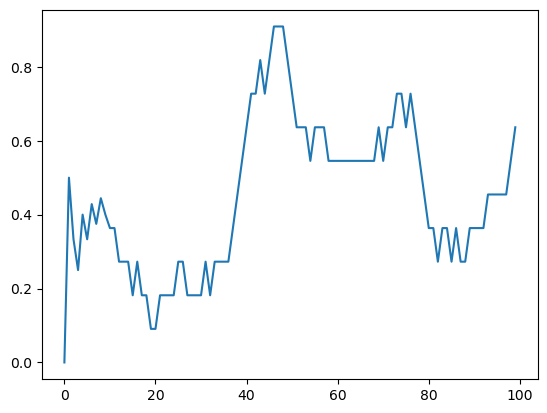

In [3]:
import matplotlib.pyplot as plt
#projective simulation must be installed locally for the following imports to work
from projective_simulation.agents.basic_PS import Basic_PSAgent
from projective_simulation.environments.rlgl import RLGL

test = Priming_ECM(num_actions = 2, action_primes = [0., 1.5])
#Number of steps to run simulation
T = 100

env = RLGL() #create a default red-light-green-light environment
agent = Basic_PSAgent(ECM = test) # create a basic PS agent using the priming ECM

for t in range(T):
    observation = env.get_observation()
    action = agent.get_action(observation)
    reward = env.get_reward(action)
    agent.update(reward)
    data_log[t] = {"env_state": env.state, "action": action, "reward": reward}
    env.transition(action)

plt.plot(range(T), [np.mean([data_log[step]["reward"] for step in range(i-10,i+1) if step >= 0]) for i in range(T)]) #plot a 10 step moving average of the reward       